In [24]:
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from keras.models import load_model


### 1. Run the feature engineering file to get the train, val, test set

[*********************100%***********************]  1 of 1 completed


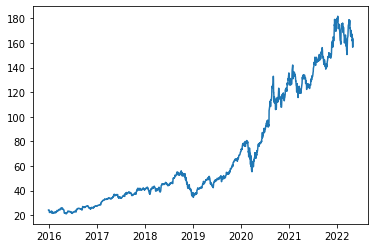

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1573 non-null   datetime64[ns]
 1   D_m3       1573 non-null   float64       
 2   D_m2       1573 non-null   float64       
 3   D_m1       1573 non-null   float64       
 4   Adj Close  1573 non-null   float64       
 5   bb_m1      1573 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.9 KB
           Date
0    2016-02-02
1    2016-02-03
2    2016-02-04
3    2016-02-05
4    2016-02-08
...         ...
1567 2022-04-22
1568 2022-04-25
1569 2022-04-26
1570 2022-04-27
1571 2022-04-28

[1572 rows x 1 columns]
         bb_m1      D_m3      D_m2      D_m1
0    -0.105413  0.007172  0.034541 -0.009349
1    -0.134903  0.034541 -0.009349 -0.020222
2    -0.108551 -0.009349 -0.020222  0.019792
3    -0.060615 -0.020222  0.019792  0.008035
4     0.042267  

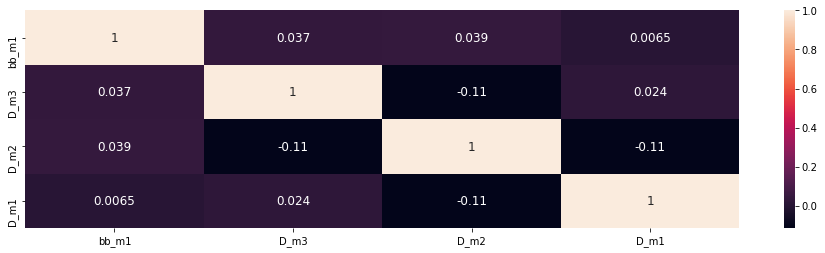

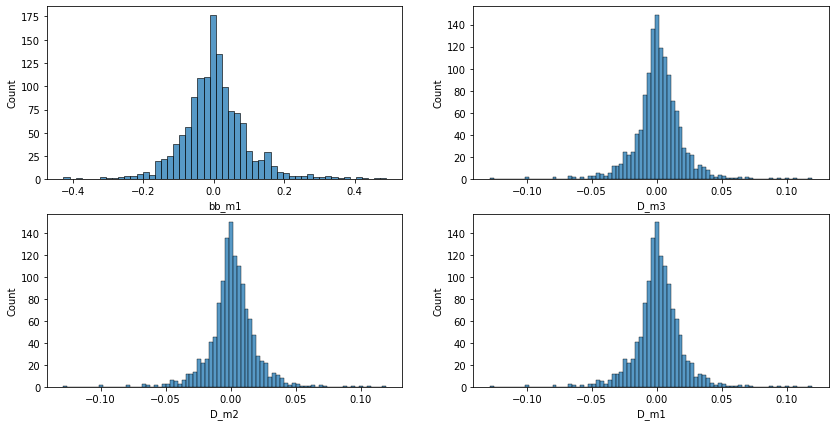

In [25]:
## Run below code to get data inclusive of Bband only with prices
%run DS105FP_ProjectScript_EdwinWan_1featureeng_final.ipynb

## Run below code to get data inclusive of MACD, MFI and BBand with prices
# %run DS105FP_ProjectScript_EdwinWan_1featureeng_initial.ipynb

### 2. Hyperparameters Tuning for the LSTM model
- Done manually through looping list of parameters dictionaries
- Performance is recorded in a df for performance comparison to see which set of parameters is the best

In [28]:
df_score = pd.DataFrame(columns = ['params_dict', 'RMSE', 'MAPE', 'R2'])
df_score

,params_dict,RMSE,MAPE,R2


In [29]:
params_dict = [{'params_dict': 1, 'n1': 64, 'n2':32, 'activation': 'relu','opt': Adam, 'lr':0.001,'ep':25},
                    {'params_dict': 2, 'n1': 64, 'n2':32, 'activation': 'relu','opt': Adam, 'lr': 0.01,'ep':25},
                    {'params_dict': 3, 'n1': 64, 'n2':32, 'activation': 'relu','opt': Adamax, 'lr': 0.001,'ep':25},
                    {'params_dict': 4, 'n1': 64, 'n2':32, 'activation': 'relu','opt':Adamax, 'lr': 0.01,'ep':25},
                    {'params_dict': 5, 'n1': 128, 'n2':64, 'activation': 'relu','opt':Adam, 'lr': 0.001,'ep':25},
                    {'params_dict': 6, 'n1': 128, 'n2':64, 'activation': 'relu','opt':Adam, 'lr': 0.01,'ep':25},
                    {'params_dict': 7, 'n1': 128, 'n2':64, 'activation': 'relu','opt':Adamax, 'lr': 0.001,'ep':25},
                    {'params_dict': 8, 'n1': 128, 'n2':64, 'activation': 'relu','opt':Adamax, 'lr': 0.01,'ep':25},
                    {'params_dict': 9, 'n1': 64, 'n2':32, 'activation': 'swish','opt':Adam, 'lr': 0.001,'ep':25},
                    {'params_dict': 10, 'n1': 64, 'n2':32, 'activation': 'swish','opt':Adam, 'lr': 0.01,'ep':25},
                    {'params_dict': 11, 'n1': 128, 'n2':64, 'activation': 'swish','opt':Adam, 'lr': 0.001,'ep':25},
                    {'params_dict': 12, 'n1': 128, 'n2':64, 'activation': 'swish','opt': Adam, 'lr': 0.01,'ep':25}
                    ]

In [30]:
count = len(params_dict)
#check which hyperparameter to use
for i in params_dict:
    #Create the LSTM model
    model = Sequential([Input((x_train.shape[1],1)),
                        LSTM(i['n1']),
                        Dense(i['n2'],activation = i['activation']), 
                        Dense(i['n2'],activation = i['activation']),
                        Dense(1)])
    model.compile(loss = 'mse',
                optimizer = i['opt'](learning_rate=i['lr']),
                metrics = ['mean_absolute_error'])
    model.fit(x_train, y_train, validation_data=(x_val, y_val.reset_index(drop=True)), epochs=i['ep'])
    count-=1
    if count>0:
        print(count,"models left to run.")
    else:
        print("All models completed")

    #Predicting the pct_chng and convert to price based on previous on the compare3 df
    test_predictions = model.predict(x_test)
    pred_test = pd.DataFrame(test_predictions, columns=['pred_test'])
    df_compare3 = dates_test.reset_index(drop=True).merge(y_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
    df_compare3 = df_compare3.merge(pred_test, how='left', left_index=True, right_index=True)
    df_compare3 = df_compare3.merge(prev_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
    df_compare3['actual_close']=(df_compare3['Adj Close']*df_compare3['prev_close'])+df_compare3['prev_close']
    df_compare3['pred_close']=(df_compare3['pred_test']*df_compare3['prev_close'])+df_compare3['prev_close']

    #Generating the metric score
    rmse = np.sqrt(np.mean(df_compare3['pred_close'] - df_compare3['actual_close'])**2)
    mape = mean_absolute_percentage_error(df_compare3['actual_close'],df_compare3['pred_close'])
    r2 = r2_score(df_compare3['actual_close'],df_compare3['pred_close'])

    #Save the score in a df
    df_score = df_score.append({'params_dict':int(i['params_dict']), 'RMSE':rmse, 'MAPE':mape, 'R2':r2}, ignore_index=True)
    


Epoch 1/25
42/42 [==============================] - 9s 51ms/step - loss: 3.6184e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3871e-04 - val_mean_absolute_error: 0.0092
Epoch 2/25
42/42 [==============================] - 1s 15ms/step - loss: 3.5722e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4264e-04 - val_mean_absolute_error: 0.0093
Epoch 3/25
42/42 [==============================] - 0s 8ms/step - loss: 3.5824e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3734e-04 - val_mean_absolute_error: 0.0092
Epoch 4/25
42/42 [==============================] - 0s 7ms/step - loss: 3.5710e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4113e-04 - val_mean_absolute_error: 0.0092
Epoch 5/25
42/42 [==============================] - 0s 7ms/step - loss: 3.5626e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3828e-04 - val_mean_absolute_error: 0.0092
Epoch 6/25
42/42 [==============================] - 0s 8ms/step - loss: 3.5669e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3754e-04 - val_mean_a

In [31]:
df_score = df_score.sort_values(by='RMSE',ascending=True)
df_score

,params_dict,RMSE,MAPE,R2
3,4.0,0.022637,0.014573,0.877943
5,6.0,0.029839,0.014561,0.878626
4,5.0,0.104479,0.014670,0.877675
9,10.0,0.120789,0.014996,0.873754
7,8.0,0.176885,0.014567,0.877529
8,9.0,0.244548,0.015038,0.874748
2,3.0,0.260701,0.014812,0.876024
10,11.0,0.294208,0.014649,0.876424
6,7.0,0.444538,0.015068,0.874106
11,12.0,0.654817,0.015326,0.871549


In [32]:
best_params = params_dict[df_score.iloc[0,0].astype(int)-1]
print(f'The best params is as follow: \n{best_params}')

The best params is as follow: 
{'params_dict': 4, 'n1': 64, 'n2': 32, 'activation': 'relu', 'opt': <class 'keras.optimizer_v2.adamax.Adamax'>, 'lr': 0.01, 'ep': 25}


### 3. Re-train the model with the best params found

In [61]:
#Create the LSTM model
model = Sequential([Input((x_train.shape[1],1)),
                    LSTM(best_params['n1']),
                    Dense(best_params['n2'],activation = best_params['activation']),
                    Dense(best_params['n2'],activation = best_params['activation']),  
                    Dense(1)])
model.compile(loss = 'mse',
              optimizer = best_params['opt'](learning_rate=best_params['lr']),
              metrics = ['mean_absolute_error'])
model.fit(x_train, y_train, validation_data=(x_val, y_val.reset_index(drop=True)), epochs=best_params['ep'])

Epoch 1/25
42/42 [==============================] - 6s 40ms/step - loss: 4.2573e-04 - mean_absolute_error: 0.0145 - val_loss: 1.4739e-04 - val_mean_absolute_error: 0.0095
Epoch 2/25
42/42 [==============================] - 0s 10ms/step - loss: 3.6206e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3733e-04 - val_mean_absolute_error: 0.0092
Epoch 3/25
42/42 [==============================] - 0s 8ms/step - loss: 3.5691e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4095e-04 - val_mean_absolute_error: 0.0092
Epoch 4/25
42/42 [==============================] - 0s 8ms/step - loss: 3.6180e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3756e-04 - val_mean_absolute_error: 0.0092
Epoch 5/25
42/42 [==============================] - 0s 8ms/step - loss: 3.5772e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3847e-04 - val_mean_absolute_error: 0.0092
Epoch 6/25
42/42 [==============================] - 0s 9ms/step - loss: 3.5949e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3871e-04 - val_mean_a

### 4. Predict and check performance for train, val and test set with tuned model

In [62]:
train_predictions = model.predict(x_train)
train_predictions

array([[ 0.00079809],
       [ 0.00310702],
       [ 0.00147063],
       ...,
       [ 0.00027804],
       [ 0.00053471],
       [-0.00074061]], dtype=float32)

In [63]:
pred_train = pd.DataFrame(train_predictions, columns=['pred_train'])
pred_train

,pred_train
0,0.000798
1,0.003107
2,0.001471
3,0.000165
4,0.000518
...,...
1331,-0.000996
1332,-0.000245
1333,0.000278
1334,0.000535


In [64]:
df_compare = dates_train.merge(y_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(pred_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(prev_train, how='left', left_index=True, right_index=True)
df_compare['actual_close']=(df_compare['Adj Close']*df_compare['prev_close'])+df_compare['prev_close']
df_compare['pred_close']=(df_compare['pred_train']*df_compare['prev_close'])+df_compare['prev_close']
df_compare

,Date,Adj Close,pred_train,prev_close,actual_close,pred_close
0,2016-02-02,-0.020222,0.000798,22.169813,21.721502,22.187507
1,2016-02-03,0.019792,0.003107,21.721502,22.151423,21.788991
2,2016-02-04,0.008035,0.001471,22.151423,22.329414,22.183999
3,2016-02-05,-0.026708,0.000165,22.329414,21.733036,22.333106
4,2016-02-08,0.010530,0.000518,21.733036,21.961884,21.744294
...,...,...,...,...,...,...
1331,2021-05-17,-0.009259,-0.000996,126.912178,125.737160,126.785825
1332,2021-05-18,-0.011246,-0.000245,125.737160,124.323151,125.706375
1333,2021-05-19,-0.001282,0.000278,124.323151,124.163826,124.357718
1334,2021-05-20,0.021012,0.000535,124.163826,126.772766,124.230218


In [65]:
rmse = np.sqrt(np.mean(df_compare['pred_close'] - df_compare['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare['actual_close'],df_compare['pred_close'])
r2 = r2_score(df_compare['actual_close'],df_compare['pred_close'])

print(f"The RMSE for train set is: {rmse}")
print(f"The MAPE for train set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for train set is: 0.055879947245879344
The MAPE for train set is: 0.012583644636671467
The R2 Score for test set is: 0.9981301567988525


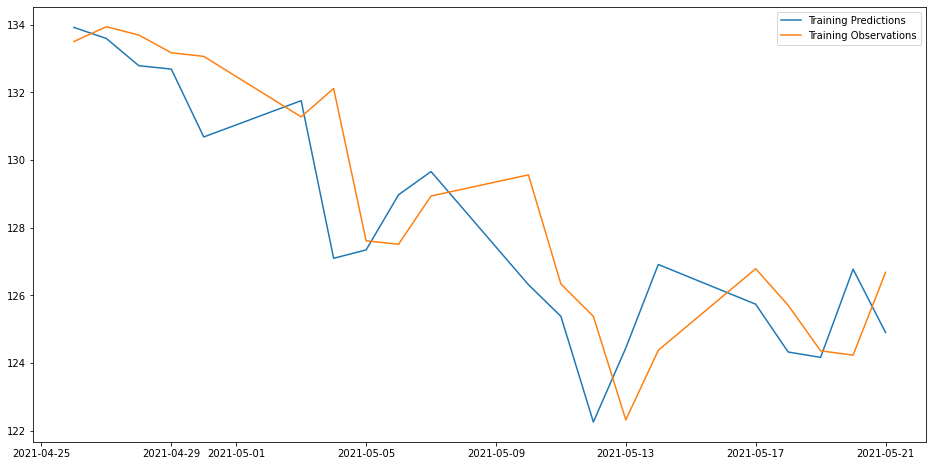

In [66]:
plt.figure(figsize=(16,8))
plt.plot(df_compare['Date'].tail(20), df_compare['actual_close'].tail(20))
plt.plot(df_compare['Date'].tail(20), df_compare['pred_close'].tail(20))
plt.legend(['Training Predictions', 'Training Observations'])



In [67]:
val_predictions = model.predict(x_val)
pred_val = pd.DataFrame(val_predictions, columns=['pred_val'])


In [68]:
df_compare2 = dates_val.reset_index(drop=True).merge(y_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(pred_val, how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(prev_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2['actual_close']=(df_compare2['Adj Close']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2['pred_close']=(df_compare2['pred_val']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2

,Date,Adj Close,pred_val,prev_close,actual_close,pred_close
0,2021-05-24,0.013314,0.000737,124.900703,126.563652,124.992787
1,2021-05-25,-0.001574,0.000410,126.563652,126.364494,126.615519
2,2021-05-26,-0.000394,0.001464,126.364494,126.314713,126.549514
3,2021-05-27,-0.012377,0.001379,126.314713,124.751343,126.488935
4,2021-05-28,-0.005348,0.002914,124.751343,124.084160,125.114893
...,...,...,...,...,...,...
105,2021-10-21,0.001474,-0.000694,148.852829,149.072235,148.749582
106,2021-10-22,-0.005285,-0.000644,149.072235,148.284393,148.976184
107,2021-10-25,-0.000336,-0.000102,148.284393,148.234528,148.269325
108,2021-10-26,0.004575,-0.000229,148.234528,148.912674,148.200616


In [69]:
rmse = np.sqrt(np.mean(df_compare2['pred_close'] - df_compare2['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare2['actual_close'],df_compare2['pred_close'])
r2 = r2_score(df_compare2['actual_close'],df_compare2['pred_close'])

print(f"The RMSE for validation set is: {rmse}")
print(f"The MAPE for validation set is: {mape}")
print(f"The R2 Score for validation set is: {r2}")

The RMSE for validation set is: 0.16546045134257356
The MAPE for validation set is: 0.009201217545238125
The R2 Score for validation set is: 0.9597204444652833


In [70]:
test_predictions = model.predict(x_test)
pred_test = pd.DataFrame(test_predictions, columns=['pred_test'])

In [71]:
df_compare3 = dates_test.reset_index(drop=True).merge(y_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(pred_test, how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(prev_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3['actual_close']=(df_compare3['Adj Close']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3['pred_close']=(df_compare3['pred_test']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3

,Date,Adj Close,pred_test,prev_close,actual_close,pred_close
0,2021-10-28,0.024992,-0.000157,148.443954,152.153809,148.420723
1,2021-10-29,-0.018156,-0.001090,152.153809,149.391357,151.988034
2,2021-11-01,-0.005607,0.000201,149.391357,148.553650,149.421455
3,2021-11-02,0.007116,0.001665,148.553650,149.610764,148.800923
4,2021-11-03,0.009799,0.000776,149.610764,151.076752,149.726911
...,...,...,...,...,...,...
121,2022-04-22,-0.027821,-0.000176,166.419998,161.789993,166.390662
122,2022-04-25,0.006737,0.000723,161.789993,162.880005,161.906893
123,2022-04-26,-0.037328,0.000117,162.880005,156.800003,162.899117
124,2022-04-27,-0.001467,0.001045,156.800003,156.570007,156.963878


In [72]:
rmse = np.sqrt(np.mean(df_compare3['pred_close'] - df_compare3['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare3['actual_close'],df_compare3['pred_close'])
r2 = r2_score(df_compare3['actual_close'],df_compare3['pred_close'])

print(f"The RMSE for test set is: {rmse}")
print(f"The MAPE for test set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for test set is: 0.04452293775762041
The MAPE for test set is: 0.014594977863584461
The R2 Score for test set is: 0.877343528065697


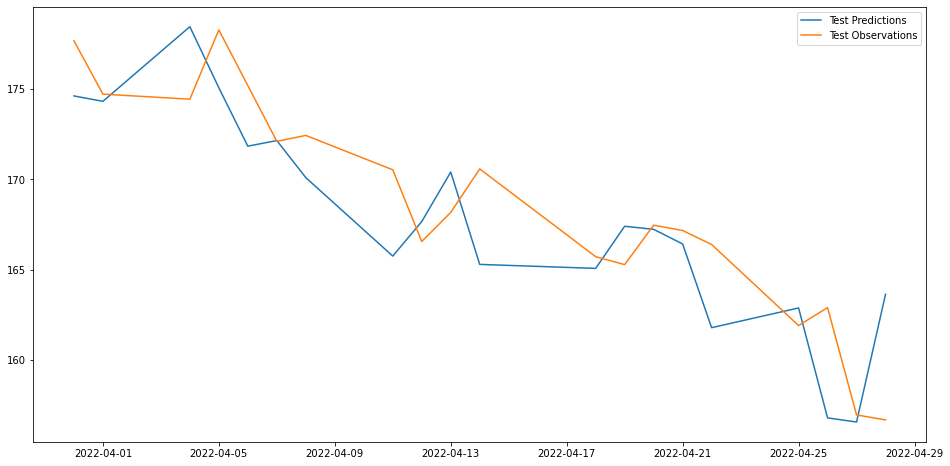

In [73]:
plt.figure(figsize=(16,8))
plt.plot(df_compare3['Date'].tail(20), df_compare3['actual_close'].tail(20))
plt.plot(df_compare3['Date'].tail(20), df_compare3['pred_close'].tail(20))
plt.legend(['Test Predictions', 'Test Observations'])

### 5. Save the model using the Keras save() function for actual prediction in 3. Forward test file 

In [74]:
model.save('my_model.h5')